In [1]:
!pip install tqdm

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 4.2 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [3]:
import importlib
import matplotlib.pyplot as plt
import numpy as np
rng = np.random.default_rng(seed=12345)
from tqdm import tqdm

import users
importlib.reload(users);
import utils
importlib.reload(utils);

In [4]:
# Horstein Algorithm

In [5]:
#  Horstein algorithm
class Horstein:

    def __init__(self, num_targets, f0=0, f1=0):
        self.num_targets = num_targets
        self.targets = np.arange(self.num_targets)
        self.f0 = f0
        self.f1 = f1

        self.q = None # belief PDF over symbols

    def reset(self):
        # initialise belief to uniform
        self.q = np.ones(self.num_targets) / self.num_targets
        return self.median()

    def step(self, action):
        median = self.median()
        self.q[np.isclose(self.targets,median)] *= 0.5 # user feedback is equally likely 0 and 1 at the target
        if action == 0: # received input 0
            self.q[self.targets < median] *= (1-self.f0) # probability of lower target and input not flipped
            self.q[self.targets > median] *= self.f1 # probability of higher target and input flipped
        elif action == 1:
            self.q[self.targets < median] *= self.f0 # probability of lower target and input flipped
            self.q[self.targets > median] *= (1-self.f1) # probability of higher target and input not flipped
        
        self.q /= self.q.sum()
        return self.median()
        
    def median(self):
        F = np.cumsum(self.q)
        return self.targets[np.argmin( (F-0.5)**2 )]

    def entropy(self):
        return -(self.q * np.log2(self.q)).sum()

In [6]:
def run_experiment_horstein(num_targets, target, f0, f1, f0_assumed, f1_assumed, max_num_steps):
    user = users.UserSimulator(f0, f1, target, rng)
    user.reset()
    agent = Horstein(num_targets, f0_assumed, f1_assumed)

    oo_system = [agent.reset()]
    beliefs = [agent.q.copy()]
    oo_user = []
    for i in range(max_num_steps):
        
      oo_user.append(user.step(oo_system[-1]))
      oo_system.append(agent.step(oo_user[-1]))
      beliefs.append(agent.q.copy())

    return oo_system, beliefs, oo_user

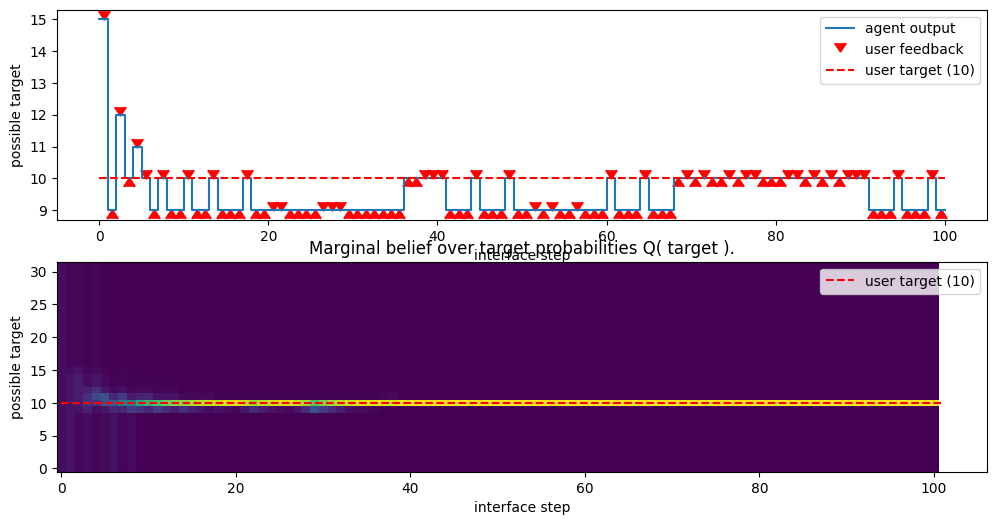

In [7]:
config = {'num_targets': 2**5, 
          'target': 10,
          'f0': 0.2,
          'f1': 0.2, 
          'f0_assumed': 0.2, 
          'f1_assumed': 0.2,
          'max_num_steps': 100}

oo_system, beliefs, oo_user = run_experiment_horstein(**config)

result = {'oo_system': oo_system, 'beliefs': beliefs, 'oo_user': oo_user}

fig, axes = plt.subplots(2, 1, figsize=(12, 2*3))
utils.plot_interaction_sequence(oo_user, oo_system, config['target'], ax=axes[0])
utils.plot_target_belief_distribution_sequence(beliefs, config['target'], cscale='linear', ax=axes[1])
# utils.plot_target_belief_sequence(beliefs, config['target'], ax=axes[2])
# axes[1].set_title(f"Agent belief after {config['max_num_steps']} interaction steps.")
#utils.plot_belief_distribution(beliefs[-1], config['target'], ax=axes[3])

In [8]:
# experiment 1: symmetric, known polarity
# runtime linear in num_targets, and linear in max_num_steps
# max_num_steps should scale with k (log2(num_targets))
# 210 seconds for k=5100 steps

def run_experiment_series(mode, polarity):
    print("-------------------")
    print(mode, polarity)
    print("-------------------")

    # targets
    k = 5 # k=5: 32 symbols, k=8: 256 symbols
    num_targets = 2**k
    target = np.arange(num_targets)
    
    # user error rates
    num_f = 11
    if (polarity == "unknown_polarity"):
        max_f = 1.
    elif (polarity == "known_polarity"):
        max_f = 0.5
    else:
        print("ERROR unknown polarity", polarity)
        max_f = None
        
    f0 = np.linspace(0, max_f, num_f)
    f0 = np.array([0.2])
    
    # error rate assumed by hornstein
    num_f_assumed = 21
    f0_assumed = np.linspace(0, max_f, num_f_assumed)
    f0_assumed = np.array([0.0, 0.1, 0.2, 0.3, 0.4])
    
    # repetitions
    num_repetitions = 100
    repetition = np.arange(num_repetitions)
    
    target, f0, f0_assumed, repetition = np.meshgrid(target, f0, f0_assumed, repetition)
    target = target.reshape(-1)
    f0 = f0.reshape(-1)
    f0_assumed = f0_assumed.reshape(-1)
    repetition = repetition.reshape(-1)
    num_conditions = len(target)
    
    if (mode == "symmetric"):
        f1 = f0
        f1_assumed = f0_assumed
    elif (mode == "fully_biased"):
        f1 = np.zeros_like(f0)
        f1_assumed = np.zeros_like(f0_assumed)
    else:
        print("ERROR: unknown mode", mode)
        f1 = None
    
    conditions = {'target': target, 
                  'f0': f0, 
                  'f1': f1, 
                  'f0_assumed': f0_assumed, 
                  'f1_assumed': f1_assumed
    }
    
    log = []
    
    for i in tqdm(range(num_conditions)):
        config = {'num_targets': num_targets, 
                  'target': target[i],
                  'f0': f0[i],
                  'f1': f1[i], 
                  'f0_assumed': f0_assumed[i], 
                  'f1_assumed': f1_assumed[i],
                  'max_num_steps': 20*k}
        oo_system, beliefs, oo_user = run_experiment_horstein(**config)
        result = {'oo_system': oo_system, 'beliefs': beliefs, 'oo_user': oo_user}
        log.append({'config': config, 'result': result})
    
    np.save(f'horstein_{num_targets}_{mode}_{polarity}', [{'conditions': conditions, 'experiments': log}])
    print("DONE")

In [9]:
import itertools

series = [['symmetric', 'known_polarity'], ['symmetric', 'unknown_polarity'], ['fully_biased', 'known_polarity'], ['fully_biased', 'unknown_polarity']]
series = [['fully_biased', 'known_polarity']]
for mode, polarity in series:
    run_experiment_series(mode, polarity)

-------------------
fully_biased known_polarity
-------------------


  0%|          | 0/16000 [00:00<?, ?it/s]/tmp/ipykernel_901/582291138.py:27: RuntimeWarning: invalid value encountered in divide
  self.q /= self.q.sum()
100%|██████████| 16000/16000 [02:58<00:00, 89.44it/s]


DONE


In [ ]:
print("Hello")